In [1]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pandas as pd
import scipy as sp
from itertools import combinations
import ciftools_af as ct
from random import shuffle
from scipy.stats import ttest_rel
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.anova import AnovaRM
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm

/home/fralberti/.local/lib/python3.8/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
/home/fralberti/anaconda3/lib/python3.8/site-packages/statsmodels/compat/pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
### VARIABLES TO SET BEFORE RUNNING
# directory containing subdirectories named fter subject IDs that contain the timeseries and surface files
root_dir = "/home/fralberti/Data/HCP/"
# directory where all intermediate files and the final output will be saved
output_dir = "/home/fralberti/Data/Output_misc/"
# list of IDs of subjects to include in the analyses
f = open(f'{root_dir}subj_IDs_200.txt', 'r')
subj_id = np.array(f.read().splitlines())
del f

In [3]:
### DISTANCE FROM PRIMARY REGIONS
for subj in subj_id[0:1]:
    geodist = []
    dlabel = nib.load(f'{root_dir}{subj}/Structural/{subj}.aparc.a2009s.32k_fs_LR.dlabel.nii')
    
    #calculate distance from primary regions
    for hemi in ['L','R']:
        source_labels = [f'{hemi}_S_calcarine', f'{hemi}_S_central', f'{hemi}_S_temporal_transverse']
        surface = nib.load(f'{root_dir}{subj}/Structural/{subj}.{hemi}.midthickness_MSMAll.32k_fs_LR.surf.gii')
        i = ct.gdist_label(source_labels, dlabel, surface, hemi, mean=False)
        geodist.append(i)
    prim_gdist = np.hstack([geodist[0],geodist[1]])
    prim_gdist_z = stats.zscore(prim_gdist, axis=1)
    
    # calculate 'equidistance' metric
    eq_gdist = np.zeros([1,prim_gdist.shape[1]])
    pairs = list(combinations(np.arange(3),2))
    for idx0, idx1 in pairs:
        eq_tmp = np.abs(prim_gdist[idx0]-prim_gdist[idx1])
        eq_gdist += eq_tmp
    eq_gdist = (eq_gdist - eq_gdist.min()) / (eq_gdist.max() - eq_gdist.min()) # min-max normalization
    eq_gdist = 1 - eq_gdist # inversion
    
    # caluculate maximal distance
    max_gdist = prim_gdist.prod(axis=0, keepdims=True)
    max_gdist = (max_gdist - max_gdist.min()) / (max_gdist.max() - max_gdist.min()) # min-max normalization
    
    scalars = np.vstack([eq_gdist, max_gdist, prim_gdist])
    output_path = f'{root_dir}{subj}/Structural/{subj}.gdist_prim.32k_fs_LR.dscalar.nii'
    ct.save_dscalar(scalars, dlabel, output_path, names=['eq_gdist','max_gdist', 'S_calcarine', 'S_central', 'S_temporal_transverse'])

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [4]:
# Calculate individual-level correlation coefficients

grad_zone_2 = {}
eq_zone_2 = {}
spearman_df = pd.DataFrame([],columns=['ID', 'hemi', 'rho', 'pval'])
for subj in subj_id:
    zones = nib.load(f'{root_dir}/HCP_S1200_GroupAvg_v1/zones.watershed.dlabel.nii')
    grad = nib.load(f'{root_dir}{subj}/{subj}.gcca_200.32k_fs_LR.dscalar.nii').get_fdata()
    gdist = nib.load(f'{root_dir}{subj}/Structural/{subj}.gdist_prim.32k_fs_LR.dscalar.nii').get_fdata()
    for hemi in ['L', 'R']:
        brain_structure = ('CIFTI_STRUCTURE_CORTEX_LEFT' if hemi=='L' else 'CIFTI_STRUCTURE_CORTEX_RIGHT')
        offset, count, _ = ct.struct_info(brain_structure, zones)
        cortex_zones = zones.get_fdata()[20, offset:offset+count]
        
        grad_hemi = grad[0, offset:offset+count]
        gdist_hemi = gdist[0, offset:offset+count]
        z = (2 if hemi=='L' else 3)
        zone_2 = cortex_zones==z
        
        grad_zone = stats.zscore(grad_hemi[zone_2])
        gdist_zone = stats.zscore(gdist_hemi[zone_2])
        rho, pval = sp.stats.spearmanr(grad_zone, gdist_zone, alternative='greater')
        spearman_df = pd.concat([spearman_df,pd.DataFrame([[subj, hemi, rho, pval]],
                                                          columns=['ID','hemi','rho','pval'])])
        grad_zone_2[subj] = grad_hemi[zone_2]
        eq_zone_2[subj] = gdist_hemi[zone_2]

spearman_df = spearman_df.reset_index(drop=True)
spearman_df.reset_index(drop=True).to_csv(f'{output_dir}gradient_distance_r.csv', index=False)
spearman_df.head()

,ID,hemi,rho,pval
0,100206,L,0.594494,0.0
1,100206,R,0.535447,0.0
2,100307,L,0.366851,0.0
3,100307,R,0.576044,0.0
4,100408,L,0.443475,0.0


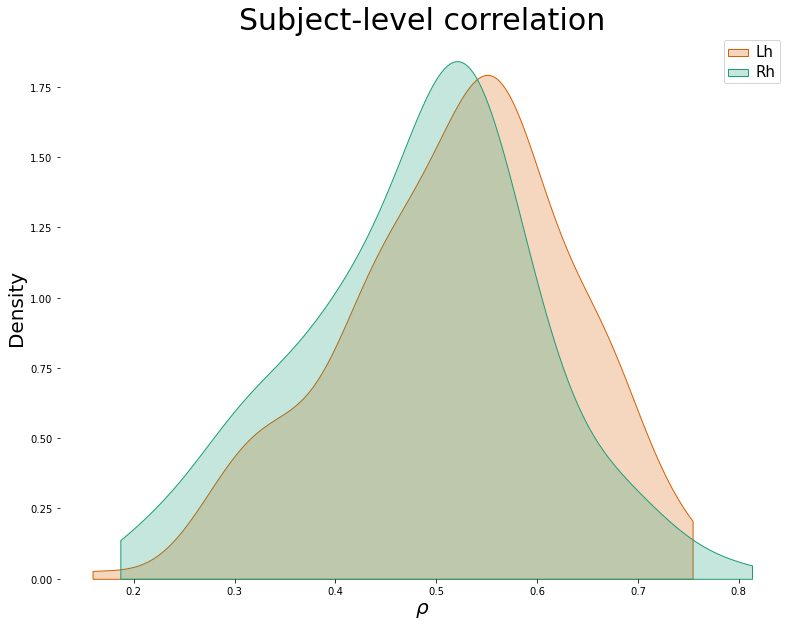

In [5]:
# plot individual rho
f = plt.figure(figsize=[13,10])
ax = sns.kdeplot(data=spearman_df, x="rho", hue='hemi', shade=True, palette='Dark2', cut=0)
ax.set_title(r"Subject-level correlation", size=30)
ax.set_xlabel(r"$\rho$", size=20)
ax.set_ylabel('Density', size=20)
ax.legend(['Lh','Rh'])
plt.setp(ax.get_legend().get_texts(), fontsize='15') # for legend text
plt.box()


In [6]:
# concatenated group-level correlation test
iter_n = 10000

# concatenate all subjects' first gradient in a vector
grad = []
for g in subj_id:
    grad.extend(grad_zone_2[g].tolist())  
eq = []
for g in subj_id:
    eq.extend(eq_zone_2[g].tolist())
rho_real, _ = sp.stats.spearmanr(grad, eq, alternative='greater')
rho_real_LR = rho_real

rho_null = []
for i in range(iter_n):
    shuffle_id = np.copy(subj_id)
    while any(shuffle_id==subj_id):
        shuffle(shuffle_id)
    grad = []
    for g in subj_id:
        grad.extend(grad_zone_2[g].tolist())  
    eq = []
    for g in shuffle_id:
        eq.extend(eq_zone_2[g].tolist())    
    rho, _ = sp.stats.spearmanr(grad, eq, alternative='greater')
    rho_null.append(rho)
rho_null_LR = rho_null

print(f'r = {rho_real_LR} \tp-value =', (100-sp.stats.percentileofscore(rho_null_LR, rho_real_LR))/100)


r = 0.5128075107097935 	p-value = 0.2647


[None, None, None, None]

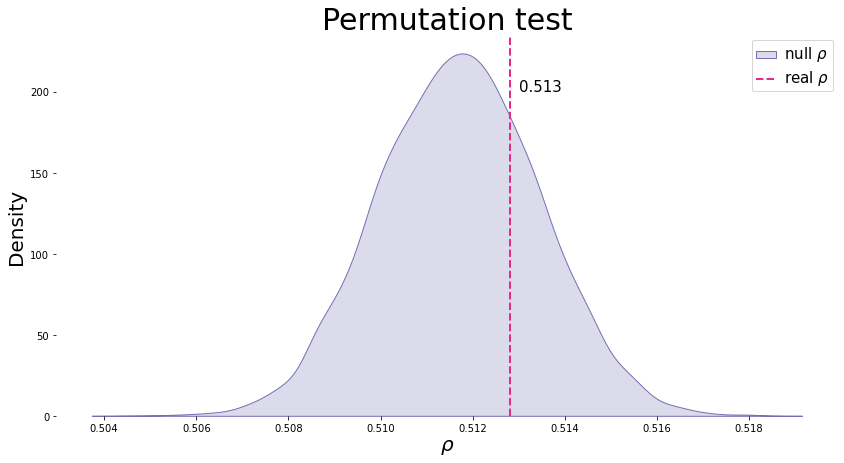

In [7]:
# Plot permutation test
cmap = sns.color_palette('Dark2',4)
f = plt.figure(figsize=[14,7])

ax = sns.kdeplot(rho_null, shade=True, color=cmap[2])
plt.axvline(rho_real, 0, color=cmap[3], linestyle='--', linewidth=2)
plt.box()
ax.set_title('Permutation test', fontsize=30)
ax.set_xlabel(r'$\rho$', size=20)
ax.set_ylabel(r'Density', size=20)
ax.text(.513,200, rho_real.round(3), fontsize=15)
ax.legend([r'null $\rho$',r'real $\rho$'])
plt.setp(ax.get_legend().get_texts(), fontsize='15')


In [8]:
# prepare data for ANOVA

# read dataframes containing gradient peak score, intersection vertices, and 
peaks_df = pd.read_csv(f'{output_dir}grad1_zone2_peak.csv', usecols=['ID','hemisphere','peak'])
ints_df = pd.read_csv(f'{output_dir}gradientiles_200.csv', usecols=['ID_vtx','hemisphere', 'vertex1', 'vertex2', 'vertex3'])

# preassign dataframe
gdist_df = pd.DataFrame(columns=['ID','hemi','target','peak','center','vector'])
for subj in subj_id:
    dist = nib.load(f'/home/fralberti/Data/HCP/{subj}/Structural/{subj}.gdist_prim.32k_fs_LR.dscalar.nii')
    dist_prim = dist.get_fdata()[2:5].T
    
    for hemi in ['L','R']:
        # extract hemisphere brain model and parameters
        brain_structure = ('CIFTI_STRUCTURE_CORTEX_LEFT' if hemi=='L' else 'CIFTI_STRUCTURE_CORTEX_RIGHT')
        brain_model = ct.struct_to_bm(brain_structure, dist)
        offset, count, vertices = ct.struct_info(brain_structure, dist)
        
        dist_prim_hemi = dist_prim[offset:offset+count,:]
        peak = peaks_df.loc[(peaks_df.ID==int(subj)) & (peaks_df.hemisphere==hemi), 'peak'].values[0]
        ints = ints_df.loc[(ints_df.ID_vtx==int(subj)) & (ints_df.hemisphere==hemi),['vertex1','vertex2','vertex3']].values[0]
        
        # get gdist from primary cortex of the peak and intersection, and the difference between them
        peak_dist = np.array(dist_prim_hemi[np.isin(vertices, peak)])[0]
        ints_dist = np.array(dist_prim_hemi[np.isin(vertices, ints)]).mean(axis=0)
        vec_dist = peak_dist - ints_dist

        gdist_df_tmp = pd.DataFrame(np.vstack([np.repeat(subj,3), np.repeat(hemi,3), np.array(['Calc S','CS','TT']),
                                               ints_dist, peak_dist, vec_dist]).T,
                                    columns=gdist_df.columns)
        gdist_df = pd.concat([gdist_df, gdist_df_tmp]).reset_index(drop=True)
        
gdist_df[['peak','center','vector']] = gdist_df[['peak','center','vector']].astype('float64')
gdist_df.to_csv(f'{output_dir}peak_gdist.csv', index=False)
        
gdist_df.head()

,ID,hemi,target,peak,center,vector
0,100206,L,Calc S,97.101051,116.840492,19.739441
1,100206,L,CS,99.215973,89.545006,-9.670967
2,100206,L,TT,87.121719,75.887718,-11.234001
3,100206,R,Calc S,104.449875,110.896942,6.447067
4,100206,R,CS,102.972969,100.521172,-2.451797


In [9]:
# calculate surface area
surf_A = []
for subj in subj_id:
    for h in ['L', 'R']:
        # surf = f'{root_dir}{subj}/Structural/{subj}.{h}.midthickness_MSMAll.32k_fs_LR.surf.gii'
        # sp.run(f'wb_command -surface-vertex-areas {surf} {root_dir}{subj}/Structural/{subj}.{h}.vertex_area.shape.gii', shell=True)
        
        A = nib.load(f'{root_dir}{subj}/Structural/{subj}.{h}.vertex_area.shape.gii')
        A = A.darrays[0].data
        dist = nib.load(f'{root_dir}{subj}/Structural/{subj}.gdist_prim.32k_fs_LR.dscalar.nii')
        brain_structure = ('CIFTI_STRUCTURE_CORTEX_LEFT' if h=='L' else 'CIFTI_STRUCTURE_CORTEX_RIGHT')
        _, _, vertices = ct.struct_info(brain_structure, dist)
        A = sum(A[vertices])
        
        surf_A.append([subj,h,A])
A_df = pd.DataFrame(surf_A,index=range(len(surf_A)), columns=['ID','hemi','A'])
A_df.to_csv(f'{root_dir}surface_area.csv', index=False)
A_df.head()

,ID,hemi,A
0,100206,L,109605.030839
1,100206,R,111940.457663
2,100307,L,100164.885101
3,100307,R,99829.245941
4,100408,L,105905.428810


In [10]:
# Correct for surface area
gdist_df = pd.read_csv(f'{output_dir}peak_gdist.csv')
A_df = pd.read_csv(f'{root_dir}surface_area.csv')
gdist_adj = gdist_df.merge(A_df)

for col in ['center', 'peak']:
    y = np.asarray(gdist_adj[col])
    X = np.asarray(gdist_adj['A'])
    X = np.sqrt(X)
    X = sm.add_constant(X)

    mdl = sm.OLS(y,X)
    results = mdl.fit()        
    gdist_adj[col] = results.resid
gdist_adj.head()

,ID,hemi,target,peak,center,vector,A
0,100206,L,Calc S,-0.603329,20.769535,19.739441,109605.030839
1,100206,L,CS,1.511593,-6.525951,-9.670967,109605.030839
2,100206,L,TT,-10.582661,-20.183239,-11.234001,109605.030839
3,100206,R,Calc S,5.583697,13.532741,6.447067,111940.457663
4,100206,R,CS,4.106791,3.156971,-2.451797,111940.457663


In [11]:
# 1-way ANOVA on the difference bettween geometric center and peak

mdl = AnovaRM(data=gdist_adj[gdist_adj.hemi=='L'], depvar='vector', subject='ID', within=['target'])
phoc = pairwise_tukeyhsd(gdist_adj[gdist_adj.hemi=='L'].vector, gdist_adj[gdist_adj.hemi=='L'].target, alpha=0.001)
print('Left Hemisphere: \n',mdl.fit())
print(phoc)

mdl = AnovaRM(data=gdist_adj[gdist_adj.hemi=='R'], depvar='vector', subject='ID', within=['target'])
phoc = pairwise_tukeyhsd(gdist_adj[gdist_adj.hemi=='R'].vector, gdist_adj[gdist_adj.hemi=='R'].target, alpha=0.001)
print('\nRight Hemisphere: \n', mdl.fit(), phoc)


Left Hemisphere: 
                 Anova
       F Value  Num DF  Den DF  Pr > F
--------------------------------------
target 160.3808 2.0000 398.0000 0.0000

 Multiple Comparison of Means - Tukey HSD, FWER=0.00 
group1 group2 meandiff p-adj  lower    upper   reject
-----------------------------------------------------
    CS Calc S  13.6275 0.001   9.9883  17.2667   True
    CS     TT   -7.214 0.001 -10.8532  -3.5749   True
Calc S     TT -20.8415 0.001 -24.4807 -17.2023   True
-----------------------------------------------------

Right Hemisphere: 
                 Anova
       F Value  Num DF  Den DF  Pr > F
--------------------------------------
target 164.5080 2.0000 398.0000 0.0000
 Multiple Comparison of Means - Tukey HSD, FWER=0.00 
group1 group2 meandiff p-adj  lower   upper   reject
----------------------------------------------------
    CS Calc S  13.6425 0.001 10.3233  16.9618   True
    CS     TT  -4.6372 0.001 -7.9564  -1.3179   True
Calc S     TT -18.2797 0.001 -21.599 

In [12]:
# 2-ways rmANOVA on peak's distance from primary regions
mdl = AnovaRM(data=gdist_adj, depvar='peak', subject='ID', within=['target','hemi'])
print(mdl.fit())

# post-hoc t-tests
cs_phoc = ttest_rel(gdist_adj[(gdist_adj.target=='CS') & (gdist_adj.hemi=='L')].peak, gdist_adj[(gdist_adj.target=='CS') & (gdist_adj.hemi=='R')].peak)
print('CS:\t', cs_phoc)

calcs_phoc = ttest_rel(gdist_adj[(gdist_adj.target=='Calc S') & (gdist_adj.hemi=='L')].peak, gdist_adj[(gdist_adj.target=='Calc S') & (gdist_adj.hemi=='R')].peak)
print('Calc S:\t', calcs_phoc)

tt_phoc = ttest_rel(gdist_adj[(gdist_adj.target=='TT') & (gdist_adj.hemi=='L')].peak, gdist_adj[(gdist_adj.target=='TT') & (gdist_adj.hemi=='R')].peak)
print('TT:\t', tt_phoc)

adj = multipletests([cs_phoc.pvalue, calcs_phoc.pvalue, tt_phoc.pvalue], alpha=0.01, method='Bonferroni')
adj

# post-hoc Tukey HSD
phoc = pairwise_tukeyhsd(gdist_adj[gdist_adj.hemi=='L'].peak, gdist_adj[gdist_adj.hemi=='L'].target, alpha=0.01)
print(phoc)

phoc = pairwise_tukeyhsd(gdist_adj[gdist_adj.hemi=='R'].peak, gdist_adj[gdist_adj.hemi=='R'].target, alpha=0.01)
print(phoc)

                   Anova
             F Value  Num DF  Den DF  Pr > F
--------------------------------------------
target      2861.1009 2.0000 398.0000 0.0000
hemi         187.8769 1.0000 199.0000 0.0000
target:hemi   19.9829 2.0000 398.0000 0.0000

CS:	 Ttest_relResult(statistic=-12.296669242320268, pvalue=3.2134623219665476e-26)
Calc S:	 Ttest_relResult(statistic=-11.967580143974832, pvalue=3.2380472860546935e-25)
TT:	 Ttest_relResult(statistic=-13.52608034404727, pvalue=5.434589247446992e-30)
 Multiple Comparison of Means - Tukey HSD, FWER=0.01 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
    CS Calc S   0.1581 0.8922  -0.8927  1.2089  False
    CS     TT  -9.1614  0.001 -10.2122 -8.1106   True
Calc S     TT  -9.3195  0.001 -10.3703 -8.2687   True
-----------------------------------------------------
Multiple Comparison of Means - Tukey HSD, FWER=0.01
group1 group2 meandiff p-adj  lower   upper  reject
----------------

In [13]:
# 1-way ANOVA on inter-hemispheric differences

gdist_df = pd.read_csv(f'{output_dir}peak_gdist.csv')

gdist_diff = gdist_df.loc[gdist_df.hemi=='L',['ID', 'target', 'peak']].reset_index(drop=True)
gdist_diff.peak = gdist_diff.peak - gdist_df.loc[gdist_df.hemi=='R','peak'].reset_index(drop=True)

mdl = AnovaRM(data=gdist_diff, depvar='peak', subject='ID', within=['target'])

print(mdl.fit())


from scipy.stats import ttest_rel
from statsmodels.stats.multitest import multipletests

cs_phoc = ttest_rel(gdist_diff[(gdist_diff.target=='CS')].peak, gdist_diff[(gdist_diff.target=='TT')].peak)
print('CS vs TT:\t', cs_phoc)

calcs_phoc = ttest_rel(gdist_diff[(gdist_diff.target=='CS')].peak, gdist_diff[(gdist_diff.target=='Calc S')].peak)
print('CS vs Calc S:\t', calcs_phoc)

tt_phoc = ttest_rel(gdist_diff[(gdist_diff.target=='Calc S')].peak, gdist_diff[(gdist_diff.target=='TT')].peak)
print('Calc S vs TT:\t', tt_phoc)

adj = multipletests([cs_phoc.pvalue, calcs_phoc.pvalue, tt_phoc.pvalue], alpha=0.01, method='Bonferroni')
adj

print(adj[1])

                Anova
       F Value Num DF  Den DF  Pr > F
-------------------------------------
target 19.9829 2.0000 398.0000 0.0000

CS vs TT:	 Ttest_relResult(statistic=4.651338515437451, pvalue=6.0048871884530224e-06)
CS vs Calc S:	 Ttest_relResult(statistic=0.04340419064790547, pvalue=0.9654228575130044)
Calc S vs TT:	 Ttest_relResult(statistic=4.586060427678403, pvalue=7.977009905047865e-06)
[1.80146616e-05 1.00000000e+00 2.39310297e-05]


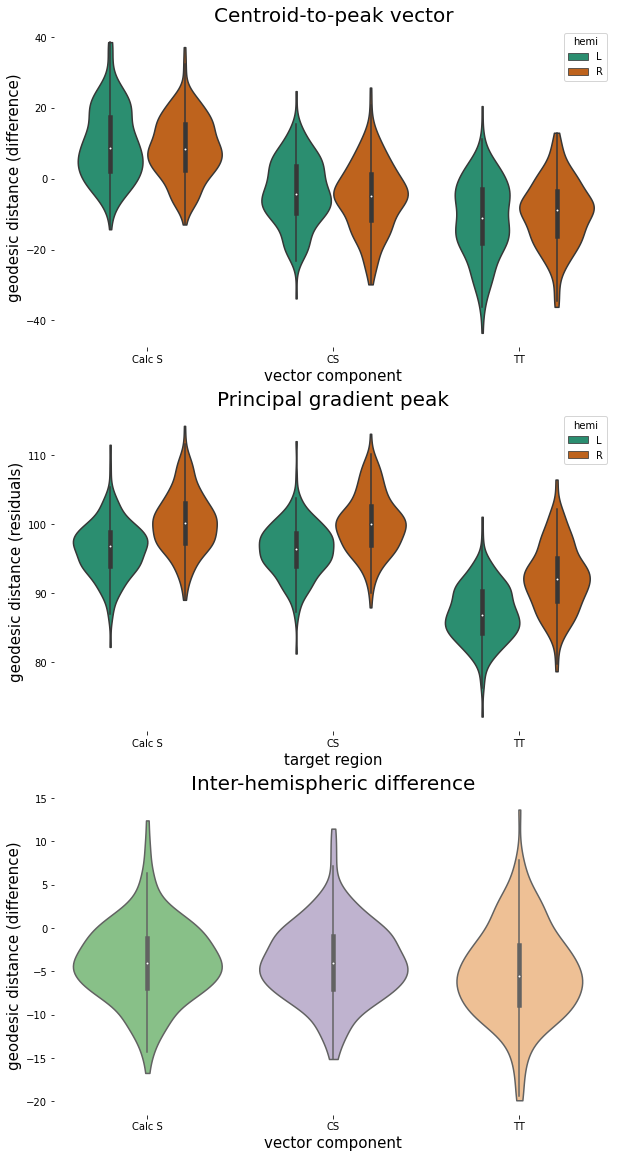

In [14]:
gdist_adj = pd.read_csv(f'{output_dir}peak_gdist.csv')
f = plt.figure(figsize=[10,20])

f.add_subplot(311)
ax = sns.violinplot(x="target", y="vector", data=gdist_adj,
               cut=0, split=False, scale_hue=True, hue='hemi',
               palette='Dark2')
plt.box()
ax.set_title('Centroid-to-peak vector', fontsize=20)
ax.set_ylabel('geodesic distance (difference)', fontsize=15)
ax.set_xlabel('vector component', fontsize=15)


f.add_subplot(312)
ax = sns.violinplot(x="target", y="peak", data=gdist_adj,
               cut=0, split=False, scale_hue=True, hue='hemi',
               palette='Dark2')
plt.box()
ax.set_title('Principal gradient peak', fontsize=20)
ax.set_ylabel('geodesic distance (residuals)', fontsize=15)
ax.set_xlabel('target region', fontsize=15)


f.add_subplot(313)
ax = sns.violinplot(x="target", y="peak", data=gdist_diff, cut=0, palette='Accent')
ax.set_title('Inter-hemispheric difference', fontsize=20)
ax.set_ylabel('geodesic distance (difference)', fontsize=15)
ax.set_xlabel('vector component', fontsize=15)
plt.box()


<AxesSubplot:xlabel='peak', ylabel='Density'>

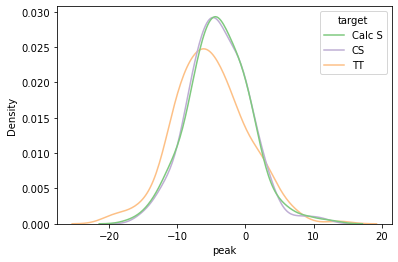

In [15]:
sns.kdeplot(data=gdist_diff, x='peak', hue='target', palette='Accent')